In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import torch
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.io import decode_image
from torchvision.transforms import Resize
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('medium')

In [2]:
class GlobalStreetscapesSample(Dataset):
    def __init__(self, dataset):
        self.img_labels = dataset
        self.resize = Resize(size=(224, 224))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join("../", self.img_labels.iloc[idx].loc["path"])
        image = decode_image(img_path, apply_exif_orientation=True)
        label = int(self.img_labels.iloc[idx].loc["label"])
        image = self.resize(image)
        return image, label

In [3]:
samples = pd.read_csv('../../data/imgs/sampled.csv', index_col=0)
paths = pd.read_csv('../../data/img_paths.csv', index_col=0)
img_labels = samples.join(paths, on='uuid', how='inner')

print("samples rows:",samples.shape[0])
print("paths rows:",paths.shape[0])
print("img_labels rows:",img_labels.shape[0])

# --- 3-Way Split: Train (70%), Val (15%), Test (15%) ---
# First, split off the Test set (15%)
train_val_df, test_df = train_test_split(
    img_labels, 
    test_size=0.15, 
    stratify=img_labels['label'], 
    random_state=42
)

# Then, split the remaining 85% into Train (70% total) and Val (15% total)
# 0.15 / 0.85 = ~0.1765
val_size = 0.15 / 0.85
train_df, val_df = train_test_split(
    train_val_df, 
    test_size=val_size, 
    stratify=train_val_df['label'], 
    random_state=42
)

print(f"Train set: {len(train_df)} images")
print(f"Val set:   {len(val_df)} images")
print(f"Test set:  {len(test_df)} images")

display(train_df.head())

training_data = GlobalStreetscapesSample(train_df)
validation_data = GlobalStreetscapesSample(val_df)
test_data = GlobalStreetscapesSample(test_df)

# Use num_workers for parallel data loading and pin_memory for faster GPU transfer
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(validation_data, batch_size=256, shuffle=False, num_workers=8, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=False, num_workers=8, pin_memory=True)

samples rows: 190693
paths rows: 200660
img_labels rows: 190693
Train set: 133485 images
Val set:   28604 images
Test set:  28604 images


,uuid,source,orig_id,city,country,iso3,s2_cell_id,label,cell_lat,cell_lon,lat,lon,path
173271,7ff09eaa-1376-4c80-afde-2d4f5172bc62,Mapillary,593470882137460,Washington,United States,USA,9923602147801300992,68,38.903330,-77.026940,38.903747,-77.026388,../data/imgs/6311a91a-5d74-424a-9e25-aa60e718e...
135712,8a801a8b-94a2-4499-bc0d-3f2761468242,Mapillary,517235949567066,Washington,United States,USA,9923602530590261248,109,38.907182,-77.026940,38.907780,-77.027070,../data/imgs/fe258837-37b6-4801-b6fa-af670b938...
67553,4aad650e-ad43-4d3c-b853-a0b3fedd6f96,Mapillary,519208835931950,Washington,United States,USA,9923602212225810432,26,38.892582,-77.034138,38.892668,-77.033703,../data/imgs/33d8e87c-4379-4f20-ba9d-ff698d87e...
8523,acc34169-906c-4b34-9f9e-afa9b1f84395,Mapillary,759177025104225,Washington,United States,USA,9923602089282371584,54,38.891921,-77.016863,38.891796,-77.016428,../data/imgs/05397744-3b04-4d68-b6c9-15efbe63f...
1672,2ca4d3ac-5b13-4401-b9e8-8cd74d477f16,Mapillary,721219845609488,Washington,United States,USA,9923602131963609088,17,38.895537,-77.020462,38.895233,-77.019883,../data/imgs/05397744-3b04-4d68-b6c9-15efbe63f...


Washington


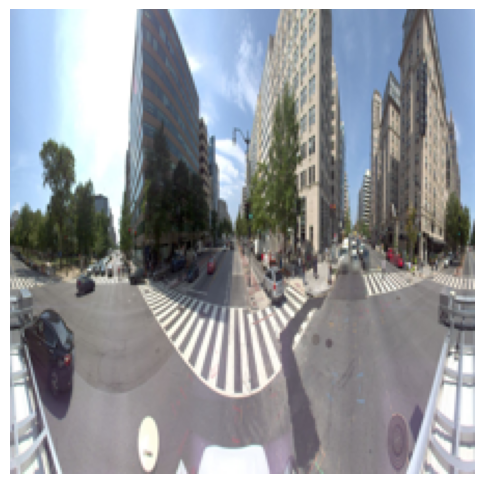

In [4]:
p = os.path.join("../", training_data.img_labels.iloc[10].loc["path"])
print(training_data.img_labels.iloc[10].loc["city"])
img = Image.open(p).convert("RGB")
img = img.resize((224, 224))
plt.figure(figsize=(6,10))
plt.imshow(img)
plt.axis("off")
plt.show()

In [5]:
# ConvNeXt Base Docs: https://pytorch.org/vision/main/models/generated/torchvision.models.convnext_base.html
weights = ConvNeXt_Base_Weights.DEFAULT
transform = weights.transforms()

model = convnext_base(weights=weights)

# ConvNeXt classifier is a Sequential block. The last layer [2] is the Linear layer.
in_features = model.classifier[2].in_features
num_classes = img_labels.label.nunique()

# Replace the default number of classes
print(f"Previous head: {model.classifier[2]}")
model.classifier[2] = torch.nn.Linear(in_features=in_features, out_features=num_classes)
print(f"New head: {model.classifier[2]}")
print(f"Number of classes: {num_classes}")

# Move to GPU with channels_last memory format for NVIDIA optimization
model = model.to(device=device, memory_format=torch.channels_last)
model = torch.compile(model)
print(f"Using device: {device}")

Previous head: Linear(in_features=1024, out_features=1000, bias=True)
New head: Linear(in_features=1024, out_features=144, bias=True)
Number of classes: 144
Using device: cuda


In [6]:
num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Changed to OneCycleLR with 10% warmup
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4,
    steps_per_epoch=len(train_dataloader),
    epochs=num_epochs,
    pct_start=0.1  # 10% of total steps used for warmup
)

# Initialize GradScaler for Automatic Mixed Precision (AMP)
# Updated to new torch.amp API
scaler = torch.amp.GradScaler('cuda')

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"EPOCH: {epoch+1}")

    # --- Training Phase ---
    current_loss = 0
    model.train()
    for inputs, labels in tqdm(train_dataloader, desc="Training"):
        # Move to GPU with non_blocking and channels_last memory format
        inputs = inputs.to(device, non_blocking=True, memory_format=torch.channels_last)
        labels = labels.to(device, non_blocking=True)
        
        inputs = transform(inputs)
        
        optimizer.zero_grad()
        
        # Runs the forward pass with autocasting (FP16)
        with torch.amp.autocast('cuda'):
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
        
        # Scales loss. Calls backward() on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()
        
        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        scheduler.step() 
        
        current_loss += loss.item()
    
    avg_train_loss = current_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        # Use val_dataloader here instead of test_dataloader
        for inputs, labels in tqdm(val_dataloader, desc="Validation", leave=False):
            inputs = inputs.to(device, non_blocking=True, memory_format=torch.channels_last)
            labels = labels.to(device, non_blocking=True)
            
            inputs = transform(inputs)
            
            # AMP for validation as well
            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
            running_val_loss += loss.item()
            
    avg_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.3f} | Val Loss: {avg_val_loss:.3f}")
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}")
    
    torch.save(model.state_dict(), f'convnext_base_epoch{epoch}.pth')

EPOCH: 1


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 4.663 | Val Loss: 3.727
LR: 0.000052
EPOCH: 2


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 2.885 | Val Loss: 2.161
LR: 0.000100
EPOCH: 3


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 1.979 | Val Loss: 1.784
LR: 0.000099
EPOCH: 4


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 1.634 | Val Loss: 1.629
LR: 0.000097
EPOCH: 5


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 1.427 | Val Loss: 1.532
LR: 0.000093
EPOCH: 6


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 1.280 | Val Loss: 1.480
LR: 0.000088
EPOCH: 7


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 1.176 | Val Loss: 1.449
LR: 0.000082
EPOCH: 8


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 1.096 | Val Loss: 1.425
LR: 0.000075
EPOCH: 9


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 1.038 | Val Loss: 1.405
LR: 0.000067
EPOCH: 10


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.996 | Val Loss: 1.397
LR: 0.000059
EPOCH: 11


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.962 | Val Loss: 1.393
LR: 0.000050
EPOCH: 12


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.939 | Val Loss: 1.382
LR: 0.000041
EPOCH: 13


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.923 | Val Loss: 1.377
LR: 0.000033
EPOCH: 14


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.910 | Val Loss: 1.379
LR: 0.000025
EPOCH: 15


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.900 | Val Loss: 1.371
LR: 0.000018
EPOCH: 16


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.893 | Val Loss: 1.371
LR: 0.000012
EPOCH: 17


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.888 | Val Loss: 1.370
LR: 0.000007
EPOCH: 18


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.885 | Val Loss: 1.367
LR: 0.000003
EPOCH: 19


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.883 | Val Loss: 1.366
LR: 0.000001
EPOCH: 20


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.882 | Val Loss: 1.366
LR: 0.000000


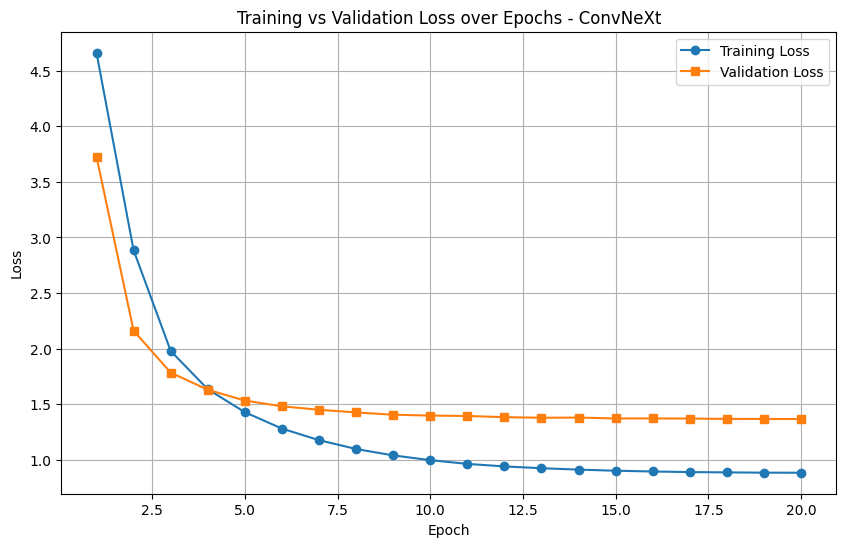

In [7]:
# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, marker='s', label='Validation Loss')
plt.title('Training vs Validation Loss over Epochs - ConvNeXt')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
METERS_PER_DEG_LAT = 111_000  # ~111 km per degree latitude
METERS_PER_DEG_LON = 86_500   # ~86.5 km per degree longitude at 38.9°N

def euclidean_distance_meters(pred_lat, pred_lon, true_lat, true_lon):
    """
    Calculate approximate Euclidean distance in meters between coordinates.
    Valid for small areas where Earth's curvature is negligible.
    """
    dlat_m = (pred_lat - true_lat) * METERS_PER_DEG_LAT
    dlon_m = (pred_lon - true_lon) * METERS_PER_DEG_LON
    return torch.sqrt(dlat_m**2 + dlon_m**2)

def batch_distance(predicted, actual):
    batch_distance = 0
    
    predicted_latlon = torch.tensor([
        (cell_id_dict[int(label)]['cell_lat'], cell_id_dict[int(label)]['cell_lon'])
        for label in predicted
    ])
    
    labels_latlon = torch.tensor([
        (cell_id_dict[int(label)]['cell_lat'], cell_id_dict[int(label)]['cell_lon'])
        for label in actual
    ])

    for i in range(len(labels_latlon)):
        pred = predicted_latlon[i]
        label = labels_latlon[i]
        distance = euclidean_distance_meters(pred[0], pred[1], label[0], label[1])
        batch_distance += distance
        
    return batch_distance

unique_cell_ids = img_labels[['label', 'cell_lat', 'cell_lon']].drop_duplicates()
cell_id_dict = unique_cell_ids.set_index('label').to_dict(orient='index')

In [ ]:
model_path = None
if model_path is not None:
    state_dict = torch.load('vit_b_16_base.pth')
    model = model.load_state_dict(state_dict)
    
model.eval()
test_loss = 0.0
correct = 0
total = 0
total_distance = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        inputs = transform(inputs)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        current_batch_distance = batch_distance(predicted, labels)
        total_distance += current_batch_distance

avg_test_loss = test_loss / len(test_dataloader)
accuracy = 100 * correct / total
avg_distance = total_distance / total

print(f"Test Loss: {avg_test_loss:.3f}")
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Average distance: {avg_distance:.3f} meters")

  0%|          | 0/112 [00:00<?, ?it/s]